## Image classification via fine-tuning with EfficientNet

<hr />

### Introduction: what is EfficientNet

EfficientNet, first introduced in <a href="https://arxiv.org/abs/1905.11946">Tan and Le, 2019</a> is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks.

The smallest base model is similar to <a href="https://arxiv.org/abs/1807.11626">MnasNet</a>, which reached near-SOTA with a significantly smaller model. By introducing a heuristic way to scale the model, EfficientNet provides a family of models (B0 to B7) that represents a good combination of efficiency and accuracy on a variety of scales. Such a scaling heuristics (compound-scaling, details see <a href="https://arxiv.org/abs/1905.11946">Tan and Le, 2019</a>) allows the efficiency-oriented base model (B0) to surpass models at every scale, while avoiding extensive grid-search of hyperparameters.

A summary of the latest updates on the model is available at <a href="https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet">here</a>, where various augmentation schemes and semi-supervised learning approaches are applied to further improve the imagenet performance of the models. These extensions of the model can be used by updating weights without changing model architecture.

<hr />

### B0 to B7 variants of EfficientNet

(This section provides some details on "compound scaling", and can be skipped if you're only interested in using the models)

Based on the <a href="https://arxiv.org/abs/1905.11946">original paper</a> people may have the impression that EfficientNet is a continuous family of models created by arbitrarily choosing scaling factor in as Eq.(3) of the paper. However, choice of resolution, depth and width are also restricted by many factors:

<ul>
    <li>Resolution: Resolutions not divisible by 8, 16, etc. cause zero-padding near boundaries of some layers which wastes computational resources. This especially applies to smaller variants of the model, hence the input resolution for B0 and B1 are chosen as 224 and 240.</li>
    <li>Depth and width: The building blocks of EfficientNet demands channel size to be multiples of 8.</li>
    <li>Resource limit: Memory limitation may bottleneck resolution when depth and width can still increase. In such a situation, increasing depth and/or width but keep resolution can still improve performance.</li>
</ul>

As a result, the depth, width and resolution of each variant of the EfficientNet models are hand-picked and proven to produce good results, though they may be significantly off from the compound scaling formula. Therefore, the keras implementation (detailed below) only provide these 8 models, B0 to B7, instead of allowing arbitray choice of width / depth / resolution parameters.

<hr />

### Keras implementation of EfficientNet

An implementation of EfficientNet B0 to B7 has been shipped with Keras since v2.3. To use EfficientNetB0 for classifying 1000 classes of images from ImageNet, run:

In [1]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

2025-04-06 03:26:47.070004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743910007.225303  535283 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743910007.289478  535283 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743910007.646089  535283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743910007.646168  535283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743910007.646175  535283 computation_placer.cc:177] computation placer alr

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


This model takes input images of shape (224, 224, 3), and the input data should be in the range [0, 255]. Normalization is included as part of the model.

Because training EfficientNet on ImageNet takes a tremendous amount of resources and several techniques that are not a part of the model architecture itself. Hence the Keras implementation by default loads pre-trained weights obtained via training with <a href="https://arxiv.org/abs/1805.09501">AutoAugment</a>.

For B0 to B7 base models, the input shapes are different. Here is a list of input shape expected for each model:

<table>
    <tr><th>Base model</th><th>resolution</th></tr>
    <tr><td>EfficientNetB0</td><td>224</td></tr>
    <tr><td>EfficientNetB1</td><td>240</td></tr>
    <tr><td>EfficientNetB2</td><td>260</td></tr>
    <tr><td>EfficientNetB3</td><td>300</td></tr>
    <tr><td>EfficientNetB4</td><td>380</td></tr>
    <tr><td>EfficientNetB5</td><td>456</td></tr>
    <tr><td>EfficientNetB6</td><td>528</td></tr>
    <tr><td>EfficientNetB7</td><td>600</td></tr>
</table>

When the model is intended for transfer learning, the Keras implementation provides a option to remove the top layers:

In [2]:
model = EfficientNetB0(include_top=False, weights='imagenet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


This option excludes the final Dense layer that turns 1280 features on the penultimate layer into prediction of the 1000 ImageNet classes. Replacing the top layer with custom layers allows using EfficientNet as a feature extractor in a transfer learning workflow.

Another argument in the model constructor worth noticing is drop_connect_rate which controls the dropout rate responsible for <a href="https://arxiv.org/abs/1603.09382">stochastic depth</a>. This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights. For example, when stronger regularization is desired, try:

In [4]:
#model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
model = EfficientNetB0(weights='imagenet')

The default value is 0.2.

<hr />

### Example: EfficientNetB0 for Stanford Dogs.

EfficientNet is capable of a wide range of image classification tasks. This makes it a good model for transfer learning. As an end-to-end example, we will show using pre-trained EfficientNetB0 on <a href="http://vision.stanford.edu/aditya86/ImageNetDogs/main.html">Stanford Dogs</a> dataset.

<hr />

### Setup and data loading

In [5]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64

### Loading data

Here we load data from <a href="https://www.tensorflow.org/datasets">tensorflow_datasets</a> (hereafter TFDS). Stanford Dogs dataset is provided in TFDS as <a href="https://www.tensorflow.org/datasets/catalog/stanford_dogs">stanford_dogs</a>. It features 20,580 images that belong to 120 classes of dog breeds (12,000 for training and 8,580 for testing).

By simply changing dataset_name below, you may also try this notebook for other datasets in TFDS such as <a href="https://www.tensorflow.org/datasets/catalog/cifar10">cifar10</a>, <a href="https://www.tensorflow.org/datasets/catalog/cifar100">cifar100</a>, <a href="https://www.tensorflow.org/datasets/catalog/food101">food101</a>, etc. When the images are much smaller than the size of EfficientNet input, we can simply upsample the input images. It has been shown in Tan and Le, 2019 that transfer learning result is better for increased resolution even if input images remain small.

In [6]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.MP00FZ_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.MP00FZ_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


When the dataset include images with various size, we need to resize them into a shared size. The Stanford Dogs dataset includes only images at least 200x200 pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [7]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

2025-04-07 03:19:10.832698: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-07 03:19:10.929779: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


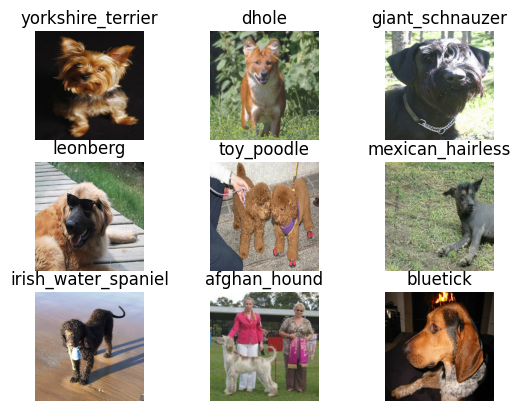

In [8]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [9]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

This Sequential model object can be used both as a part of the model we later build, and as a function to preprocess data before feeding into the model. Using them as function makes it easy to visualize the augmented images. Here we plot 9 examples of augmentation result of a given figure.

2025-04-07 03:27:02.285182: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


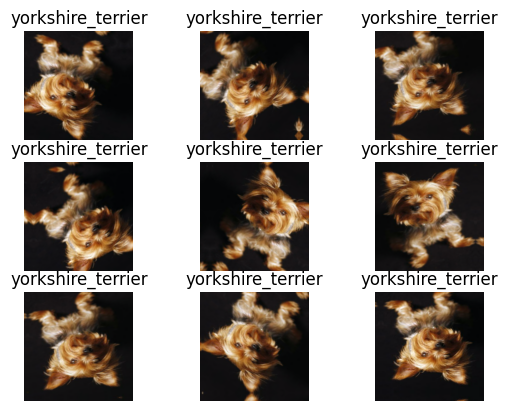

In [10]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

Prepare inputs

Once we verify the input data and augmentation are working correctly, we prepare dataset for training. The input data are resized to uniform IMG_SIZE. The labels are put into one-hot (a.k.a. categorical) encoding. The dataset is batched.

Note: prefetch and AUTOTUNE may in some situation improve performance, but depends on environment and the specific dataset used. See this guide for more information on data pipeline performance.

In [11]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

<hr />

### Training a model from scratch

We build an EfficientNetB0 with 120 output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [ ]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization_3[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40
